In [2]:
import requests, zipfile, io

zip_file_url = 'https://github.com/karoldvl/ESC-50/archive/master.zip' # link: ESC-50 Datset
datapath = './ESC-50-master/audio'




r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('./')
z.close()

In [3]:
import os
import librosa
import librosa.display
import soundfile as sf
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tqdm import tqdm 


def spetro_extraction(file):
    
    y, sr = librosa.load(file, sr=44100, duration=2)

    time = librosa.get_duration(y)
    while(time < 4):
      y = np.append(y,y)
      time = librosa.get_duration(y)
    
    y = y[:2*44100]

    S = np.abs(librosa.stft(y,sr))
    S_db = librosa.amplitude_to_db(S,ref=np.max)
    
                                   
    return S_db

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 14 15:25:41 2022

@author: Wu
"""
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten,InputLayer
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD

from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint
from keras.losses import SparseCategoricalCrossentropy



def basemodel():
      model = Sequential()
 
      model.add(Conv2D(32, (3, 3), input_shape=(22051,9,1), activation='relu', padding='same'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Flatten())
   
      model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
  
      model.add(Dense(50, activation='softmax'))

      model.compile(optimizer='Adam', 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
      return model
  
model = basemodel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22051, 9, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11025, 4, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11025, 4, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5512, 2, 64)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 705536)            0         
                                                                 
 dense (Dense)               (None, 128)               9

In [5]:
df = pd.read_csv(glob('ESC-50-master/meta/esc50.csv')[0])
df = df[['target','category']]
# df = df.drop_duplicates().reset_index(drop=True)
# df = df.sort_values(by=['target']).reset_index(drop=True)
df.head()


print(df['target'])




0        0
1       14
2       36
3       36
4       19
        ..
1995     6
1996    36
1997    25
1998     8
1999     0
Name: target, Length: 2000, dtype: int64


In [6]:
datapath = './ESC-50-master/audio'

datafile = sorted(glob(os.path.join(datapath, '*.wav')))

# get train data and label
features= []
labels = []

for i, file in enumerate(tqdm(datafile)):

    # print("Extracting file ", file)
    label_temp = file.split("/")[-1].split("-")[-1].split(".")[0]
    if (label_temp == "0") or (label_temp == "5") or (label_temp == "10") or (label_temp == "19") or (label_temp == "22") :
      features.append(spetro_extraction(file))

        # print(np.array(features).shape)
      labels.append([label_temp])
        #print(label_temp)

features = np.array(features)
labels = np.array(labels,dtype = np.int)
print(features.shape)
print(labels.shape)
# labels = np_utils.to_categorical(labels, num_classes=50)

100%|██████████| 2000/2000 [00:03<00:00, 574.20it/s]

(200, 22051, 9)
(200, 1)


(22051, 9)
49
7.6293945e-06
1.0
(39691800, 1)
    target          category
0        0               dog
1        1           rooster
2        2               pig
3        3               cow
4        4              frog
5        5               cat
6        6               hen
7        7           insects
8        8             sheep
9        9              crow
10      10              rain
11      11         sea_waves
12      12    crackling_fire
13      13          crickets
14      14    chirping_birds
15      15       water_drops
16      16              wind
17      17     pouring_water
18      18      toilet_flush
19      19      thunderstorm
20      20       crying_baby
21      21          sneezing
22      22          clapping
23      23         breathing
24      24          coughing
25      25         footsteps
26      26          laughing
27      27    brushing_teeth
28      28           snoring
29      29  drinking_sipping
30      30   door_wood_knock
31      31       mouse_cli

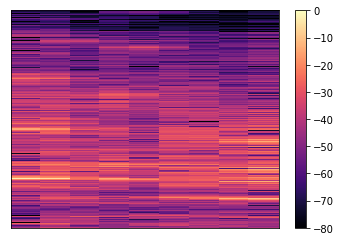

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 10 23:26:32 2022

@author: Wu
"""
import os
import librosa
import librosa.display
import soundfile as sf
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tqdm import tqdm 
from keras.preprocessing.image import ImageDataGenerator


#%%

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten,InputLayer
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint


#%% test 
s = spetro_extraction("./ESC-50-master/audio/1-9887-A-49.wav")
print(s.shape)
test = '/ESC-50-master/audio/1-9887-A-49.wav'
label = test.split("/")[-1].split("-")[-1].split(".")[0]
print(label)

plt.figure()
librosa.display.specshow(s)
plt.colorbar()

datafile = sorted(glob(os.path.join(datapath, '*.wav')))

#%%

    
#%%
features = features.reshape(-1,1)


from sklearn.preprocessing import MinMaxScaler
data = features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)

    
print(np.amax(features))

normalized_features = scaler.transform(data)
print(np.amax(normalized_features))
print(normalized_features.shape)

conv_features = np.reshape(normalized_features,(200,22051,-1,1))
# print(features_convolution.shape)
    
    
    
#%%
# get label name
df = pd.read_csv(glob('ESC-50-master/meta/esc50.csv')[0])
df = df[['target','category']]
df = df.drop_duplicates().reset_index(drop=True)
df = df.sort_values(by=['target']).reset_index(drop=True)
df.head()

print(df)

label_dict = {}
for i in range(len(df)):
    label_dict[i] = df['category'][i]
    
print(label_dict)


# data_n = np.squeeze(np.array(data))

# train:test = 7:3
#%%

print(np.array(features).shape)



onehot_labels = np_utils.to_categorical(labels, num_classes=50)

# X_train = np.squeeze(np.array(X_train))
X_train, X_test, y_train, y_test = train_test_split(conv_features, 
                            onehot_labels, 
                            test_size=0.3,
                            random_state=4)

# print(np.array(X_train).shape)
# print(np.array(X_train[100]).shape)


# X_train = np.squeeze(np.array(X_train))
if not os.path.exists('model'):
    os.makedirs('model')
    
filepath="model/weights_0.best.hdf5"



checkpoint_filepath = './checkpoint.ckpt'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



model = basemodel()

datagen = ImageDataGenerator(
              width_shift_range=0,  
              # randomly shift images horizontally (fraction of total width)
              height_shift_range=0, 
              # randomly shift images vertically (fraction of total height)
              horizontal_flip=False,  # randomly flip images
              vertical_flip=False  # randomly flip images
          )


history = model.fit(X_train, y_train,batch_size=32, 
                      validation_data=(X_test, y_test),
                      epochs=40,callbacks=[model_checkpoint_callback])

# 


model.save_weights("model.weight")



### Plot training Result

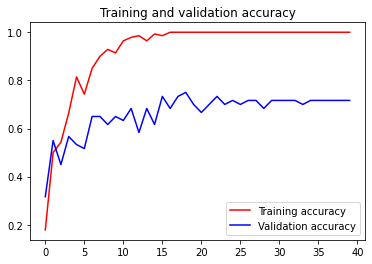

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [9]:
from keras.models import load_model

# model.load_weights(checkpoint_filepath)

### SAVE and TEST

In [12]:

datapath = './sound'
test_file = sorted(glob(os.path.join(datapath, '*.wav')))
for file in test_file:
  print(file)
  test_feature = spetro_extraction(file)

  from sklearn.preprocessing import MinMaxScaler
  data = test_feature
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler.fit(data)

      
  print(np.amax(test_feature))

  normalized_features = scaler.transform(data)
  # print(np.amax(normalized_features))
  # print(normalized_features.shape)

  test_features_convolution = np.reshape(normalized_features,(1,22051,-1,1))
  # print(test_features_convolution.shape)

  y_predict = model.predict(test_features_convolution)
  classes_y=np.argmax(y_predict,axis=1)
  print(label_dict[classes_y[0]])





./sound/cat (1).wav
0.0
cat
./sound/cat (10).wav
0.0
cat
./sound/cat (2).wav
3.8146973e-06
cat
./sound/cat (3).wav
0.0
cat
./sound/cat (4).wav
0.0
dog
./sound/cat (5).wav
0.0
clapping
./sound/cat (6).wav
0.0
cat
./sound/cat (7).wav
0.0
cat
./sound/cat (8).wav
3.8146973e-06
dog
./sound/cat (9).wav
0.0
cat
./sound/clapping (1).wav
0.0
clapping
./sound/clapping (10).wav
0.0
clapping
./sound/clapping (2).wav
0.0
clapping
./sound/clapping (3).wav
3.8146973e-06
rain
./sound/clapping (4).wav
0.0
rain
./sound/clapping (5).wav
3.8146973e-06
cat
./sound/clapping (6).wav
-3.8146973e-06
clapping
./sound/clapping (7).wav
0.0
clapping
./sound/clapping (8).wav
0.0
clapping
./sound/clapping (9).wav
0.0
clapping
./sound/dog (1).wav
0.0
dog
./sound/dog (10).wav
0.0
cat
./sound/dog (2).wav
0.0
dog
./sound/dog (3).wav
0.0
clapping
./sound/dog (4).wav
0.0
clapping
./sound/dog (5).wav
3.8146973e-06
cat
./sound/dog (6).wav
0.0
dog
./sound/dog (7).wav
0.0
dog
./sound/dog (8).wav
0.0
rain
./sound/dog (9).wav
3